Synchronize DLC results with xr_session

In [1]:
%reload_ext autoreload
%autoreload 2
from trialexp.process.deeplabcut import utils as dlc_utils
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import Video
import seaborn as sns
from trialexp.process.pyphotometry.utils import make_event_xr, extract_event_data
from moviepy.editor import *


In [2]:
fn = '06-14-23_14-40-49.000_TT002_Rig_3_Side_recode'
session_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT002-2023-06-14-144112/'
videofile = session_path +f'video/{fn}.mp4'

# Load DLC results

In [3]:
dftip = pd.read_pickle('dftip.pkl')
dfwrist = pd.read_pickle('dfwrist.pkl')

In [4]:
dftip = dlc_utils.add_video_timestamp(dftip, videofile)
dfwrist = dlc_utils.add_video_timestamp(dfwrist, videofile)    

In [5]:
xr_dlc = xr.DataArray([dfwrist,dftip], dims=('marker','time','coords'),
                 coords={'marker':['wrist','tip'],
                         'time':dfwrist.index,
                         'coords':['x','y','likelihood']
                 })

## Synchronize with the xr_session

In [6]:
xr_session = xr.open_dataset(session_path+'/processed/xr_session.nc')

# resample to the xr_session time
xr_dlc = xr_dlc.interp(time=xr_session.time)
xr_session['dlc_markers'] = xr_dlc

In [7]:
xr_session.to_netcdf('xr_session_dlc.nc', engine='h5netcdf')

In [8]:
wrist_loc = xr_session['dlc_markers'].loc['wrist',:,['x','y']]
tip_loc = xr_session['dlc_markers'].loc['tip',:,['x','y']]

## Analyze movement data

In [9]:
signal_time, coords, speed, accel = dlc_utils.get_movement_metrics(wrist_loc)
speed_mag = np.linalg.norm(speed,axis=1)
accel_mag = np.diff(speed_mag, prepend=speed_mag[0])

**Direction of axis in image:**

- x: increase from left to right
- y: increase from top to bottom
- speed_x: -ve : left
- speed_y: -ve : up

In [10]:
f = xr_session.zscored_df_over_f.data[0]

df_move = pd.DataFrame({
    'accel': accel_mag,
    'accel_x': accel[:,0],
    'accel_y': accel[:,1],
    'speed': speed_mag,
    'speed_x': speed[:,0],
    'speed_y': speed[:,1],
    'x' : coords[:,0],
    'y' : coords[:,1],
    'time': xr_session.time,
    'df/f': f})
df_move

,accel,accel_x,accel_y,speed,speed_x,speed_y,x,y,time,df/f
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,866.019236,718.237255,7608.5,0.205254
1,0.057733,0.014156,-0.055971,0.057733,0.014156,-0.055971,866.033392,718.181284,7618.5,0.292358
2,-0.014141,0.028642,0.047690,0.043592,0.042798,-0.008280,866.076190,718.173004,7628.5,0.262030
3,0.027108,0.027034,-0.002757,0.070699,0.069833,-0.011037,866.146023,718.161967,7638.5,0.201862
4,0.015841,0.012326,-0.016152,0.086541,0.082158,-0.027190,866.228181,718.134777,7648.5,0.231352
...,...,...,...,...,...,...,...,...,...,...
176423,0.047227,-1.242300,0.265860,0.658829,-0.644407,0.137092,870.201456,747.134276,1771827.5,0.003056
176424,2.613453,-2.555329,0.548121,3.272282,-3.199736,0.685213,867.001720,747.819489,1771837.5,0.031638
176425,1.856771,-1.815902,0.387428,5.129054,-5.015639,1.072641,861.986081,748.892130,1771847.5,0.086082
176426,-0.771006,0.751912,-0.170858,4.358047,-4.263727,0.901783,857.722354,749.793913,1771857.5,0.064148


## Study movement termination

In [76]:
is_rest = ((df_move.speed<2) & (df_move.accel.abs()<3)).astype(np.int8)
df_move['is_rest'] = is_rest
move_term_idx = np.where(np.diff(is_rest, prepend=False)==1)[0]
move_term_time = df_move.iloc[move_term_idx].time

def filter_term(df_move, move_term_idx, consec_rest, consec_move):
    # filter move init only if it is proceed by some amount of consec_rest
    # followed by consec_move of movement
    # allow for some tolerance as there may be tracking error
    
    valid_term = []
    for idx in move_term_idx:
        before_cond = df_move.iloc[(idx-consec_move):idx].is_rest.mean() < 0.1 #moving
        after_cond = df_move.iloc[idx:(idx+consec_rest)].is_rest.mean() > 0.9 #stopped
        if (before_cond and after_cond):
            valid_term.append(idx)
            
    return valid_term

valid_term = filter_term(df_move, move_term_idx,50, 10)
valid_term_time = df_move.iloc[valid_term].time
len(valid_term_time)

208

all init: 6512 valid init : 208


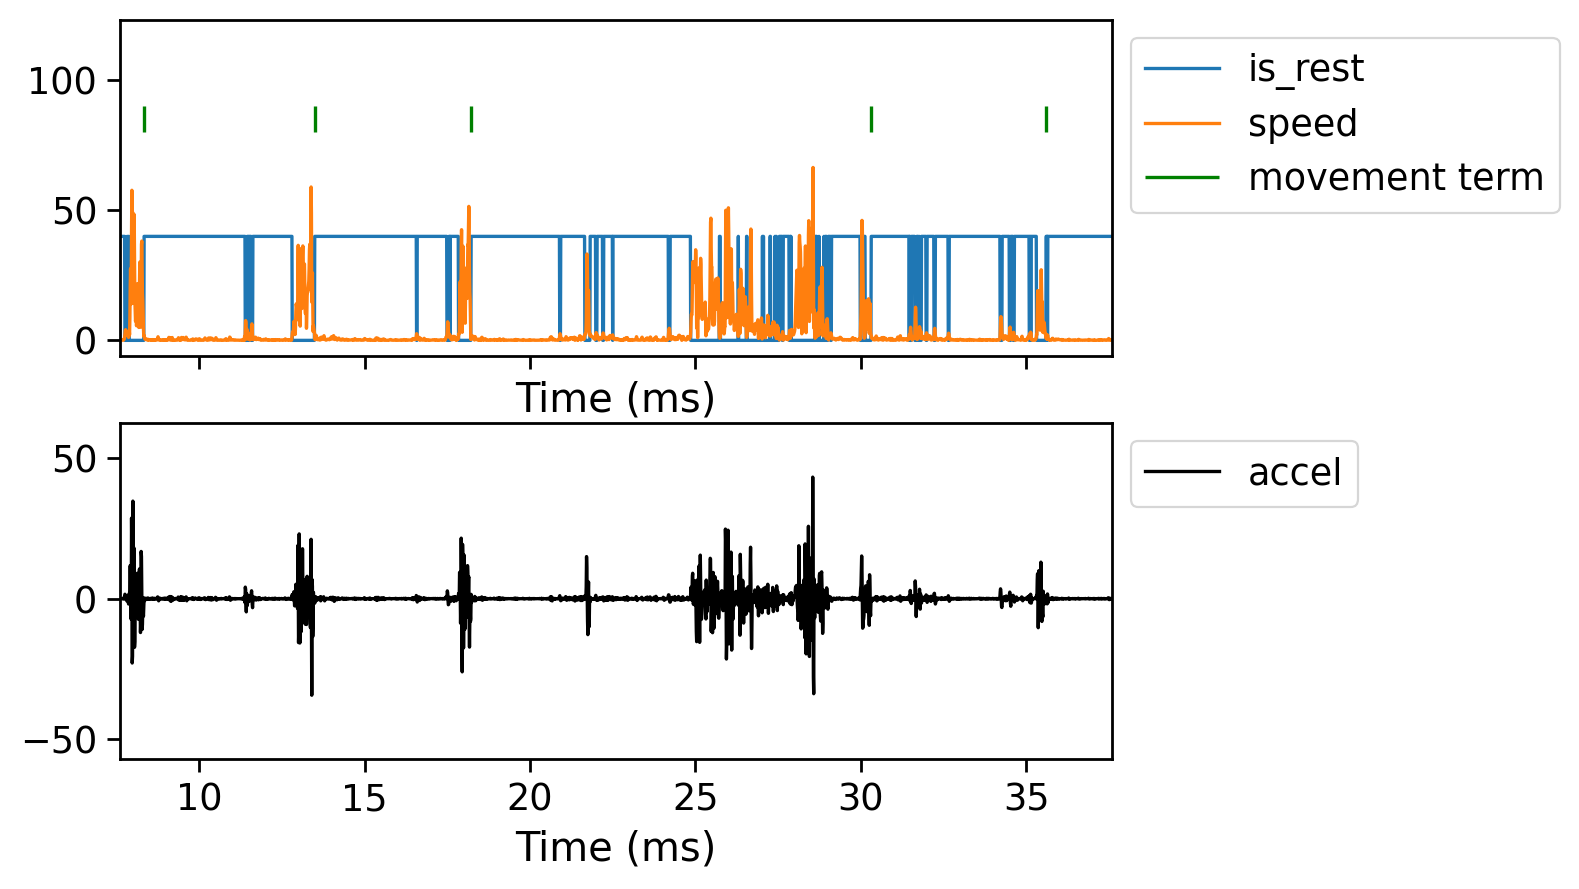

In [88]:
sns.set_context('paper', font_scale=1.5)

df2plot = df_move
time = df_move.time/1000

fig,ax = plt.subplots(2,1,sharex=True, dpi=200)


ax[0].plot(time, is_rest*40, label='is_rest')
ax[0].plot(time, df2plot.speed, label='speed')

ax[1].plot(time, df2plot.accel, label='accel',color='k')
ax[1].set_xlabel('Time (ms)')
ax[1].legend(bbox_to_anchor=[1,1], loc='upper left')

ax[0].set_xlim([time[0],time[0]+30])


ax[0].eventplot(time[valid_term], lineoffsets = 85, linelength=10, color='g', label='movement term')
ax[0].set_xlabel('Time (ms)')
ax[0].legend(bbox_to_anchor=[1,1], loc='upper left')

# fig.tight_layout()

# fig.savefig('move_init.png',dpi=200, bbox_inches='tight')

print(f'all init: {len(move_term_idx)} valid init : {len(valid_term)}')

Extracted 207 events


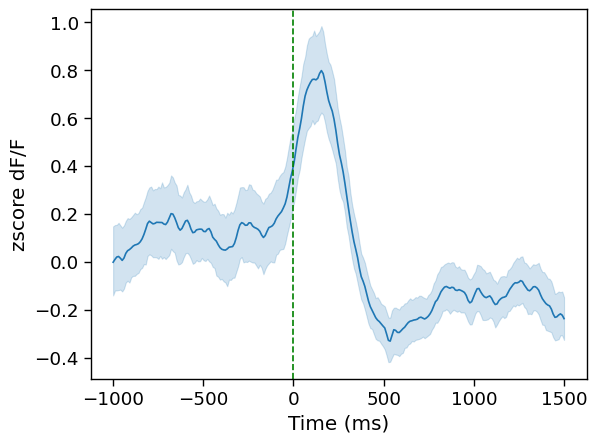

In [78]:
# xr_sessoin is at 100Hz

df_term = dlc_utils.extract_triggered_data(valid_term_time, xr_session, [-1000, 1500],
                                             sampling_rate=100)
ax = sns.lineplot(df_term, x='event_time', y='photometry')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_move_term.png', bbox_inches='tight', dpi=200)

In [79]:
dlc_utils.extract_sample_video_multi(videofile, 'move_term', 
                                     valid_term_time[:5].values, video_type='gif', resize_ratio=0.5)

Saved sample_video/move_term_18
Saved sample_video/move_term_13
Saved sample_video/move_term_30
Saved sample_video/move_term_8
Saved sample_video/move_term_35


### Separate into forward and backward movement

In [97]:
direction = dlc_utils.get_direction(df_move, valid_term, win_dir = 'before')
speed = dlc_utils.get_average_speed(df_move, valid_term, win_dir = 'before')
accel = dlc_utils.get_average_value(df_move,'accel', valid_term, win_dir = 'before')
x = dlc_utils.get_average_value(df_move,'x', valid_term, win_dir='after')
y = dlc_utils.get_average_value(df_move,'y', valid_term, win_dir='after')

mov_type = dlc_utils.get_movement_type(df_move, valid_term, 100, window=20, win_dir = 'before')
speed_cls = pd.qcut(speed,3, labels=['slow','middle','fast'])
average_photom = dlc_utils.get_average_photom(df_move, valid_term)

df_term_time =  pd.DataFrame({'event_index':np.arange(len(direction)), 
                              'term_time': valid_term_time,
                              'speed': speed,
                              'x': x,
                              'y': y,
                              'accel': accel,
                              'speed_class': speed_cls,
                              'move_type': mov_type,
                              'df/f': average_photom,
                              'direction':direction})

df_term_time.to_pickle('df_term_time.pkl')
# display(df_init_time)
display(df_term_time.groupby(['direction','move_type']).count())
df_term2 = df_term.merge(df_term_time, on='event_index')
df_term2

event_index  term_time  speed    x    y  accel  \
direction move_type                                                   
backward  reach               44         44     44   44   44     44   
          twitch             114        114    114  114  114    114   
forward   reach                2          2      2    2    2      2   
          twitch              48         48     48   48   48     48   

                     speed_class  df/f  
direction move_type                     
backward  reach               44    44  
          twitch             114   114  
forward   reach                2     2  
          twitch              48    48

,event_index,event_time,photometry,term_time,speed,x,y,accel,speed_class,move_type,df/f,direction
0,0,-1000.000000,NaN,8328.5,18.020726,848.930521,723.762990,-1.135883,fast,reach,4.422958,backward
1,0,-989.959839,NaN,8328.5,18.020726,848.930521,723.762990,-1.135883,fast,reach,4.422958,backward
2,0,-979.919679,NaN,8328.5,18.020726,848.930521,723.762990,-1.135883,fast,reach,4.422958,backward
3,0,-969.879518,NaN,8328.5,18.020726,848.930521,723.762990,-1.135883,fast,reach,4.422958,backward
4,0,-959.839357,NaN,8328.5,18.020726,848.930521,723.762990,-1.135883,fast,reach,4.422958,backward
...,...,...,...,...,...,...,...,...,...,...,...,...
51995,207,1459.839357,-1.032434,1761797.5,8.324117,547.257494,675.906361,-0.415147,slow,twitch,-0.237907,backward
51996,207,1469.879518,-0.869969,1761797.5,8.324117,547.257494,675.906361,-0.415147,slow,twitch,-0.237907,backward
51997,207,1479.919679,-0.731197,1761797.5,8.324117,547.257494,675.906361,-0.415147,slow,twitch,-0.237907,backward
51998,207,1489.959839,-0.814221,1761797.5,8.324117,547.257494,675.906361,-0.415147,slow,twitch,-0.237907,backward


,event_time,photometry,term_time,speed,x,y,accel,speed_class,move_type,df/f
direction,,,,,,,,,,
backward,44,43,44,44,44,44,44,44,44,44
forward,2,2,2,2,2,2,2,2,2,2


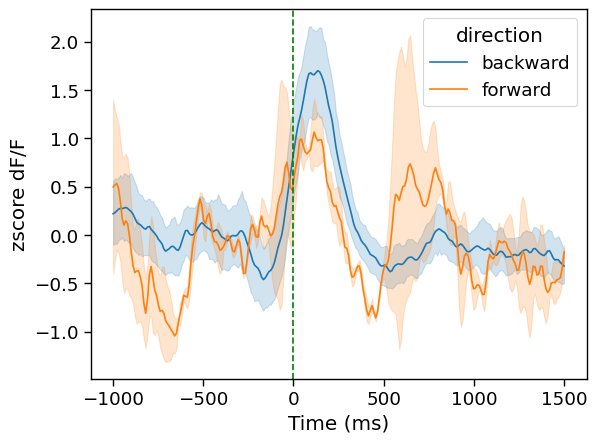

In [99]:
df2plot = df_term2[df_term2.move_type =='reach']
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

ax = sns.lineplot(df2plot, x='event_time', y='photometry', hue='direction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('zscore dF/F')
ax.axvline(0,ls='--',color='g')
plt.savefig('photom_movement_direction_term.png',dpi=200)

In [100]:
forward_time = df_term_time.query("direction=='forward' and speed_class!= 'slow'").term_time.values
backward_time = df_term_time.query("direction=='backward' and speed_class!= 'slow'").term_time.values

dlc_utils.extract_sample_video_multi(videofile, 'move_term_forward', 
                                     forward_time[:2], video_type='gif', resize_ratio=0.4)

dlc_utils.extract_sample_video_multi(videofile, 'move_term_backward', 
                                     backward_time[:2], video_type='gif', resize_ratio=0.4)

Saved sample_video/move_term_forward_54
Saved sample_video/move_term_forward_72
Saved sample_video/move_term_backward_13
Saved sample_video/move_term_backward_8


### Movement speed

,event_time,photometry,term_time,speed,x,y,accel,speed_class,move_type,df/f
direction,,,,,,,,,,
backward,44,43,44,44,44,44,44,44,44,44
forward,2,2,2,2,2,2,2,2,2,2


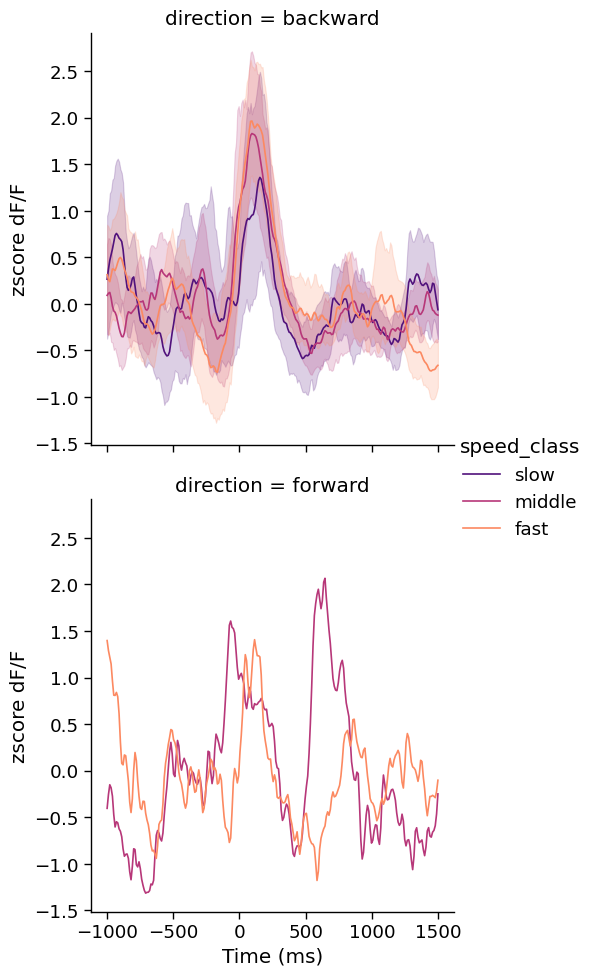

In [101]:
df2plot = df_term2[df_term2.move_type=='reach']
display(df2plot.groupby(['event_index']).first().groupby('direction').count())

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', row='direction', hue='speed_class', palette='magma')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_speed_term.png',dpi=200)

In [71]:
df_speed_class = df_term_time.groupby(['speed_class','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.speed_class}_term', 
                                     [row.term_time], video_type='gif', resize_ratio=0.4)

Saved sample_video/backward_slow_term_35
Saved sample_video/forward_slow_term_1410
Saved sample_video/backward_middle_term_103
Saved sample_video/forward_middle_term_54
Saved sample_video/backward_fast_term_8
Saved sample_video/forward_fast_term_378


## Movement type

event_index  term_time  speed    x    y  accel  \
move_type direction                                                   
reach     backward            44         44     44   44   44     44   
          forward              2          2      2    2    2      2   
twitch    backward           114        114    114  114  114    114   
          forward             48         48     48   48   48     48   

                     speed_class  df/f  
move_type direction                     
reach     backward            44    44  
          forward              2     2  
twitch    backward           114   114  
          forward             48    48

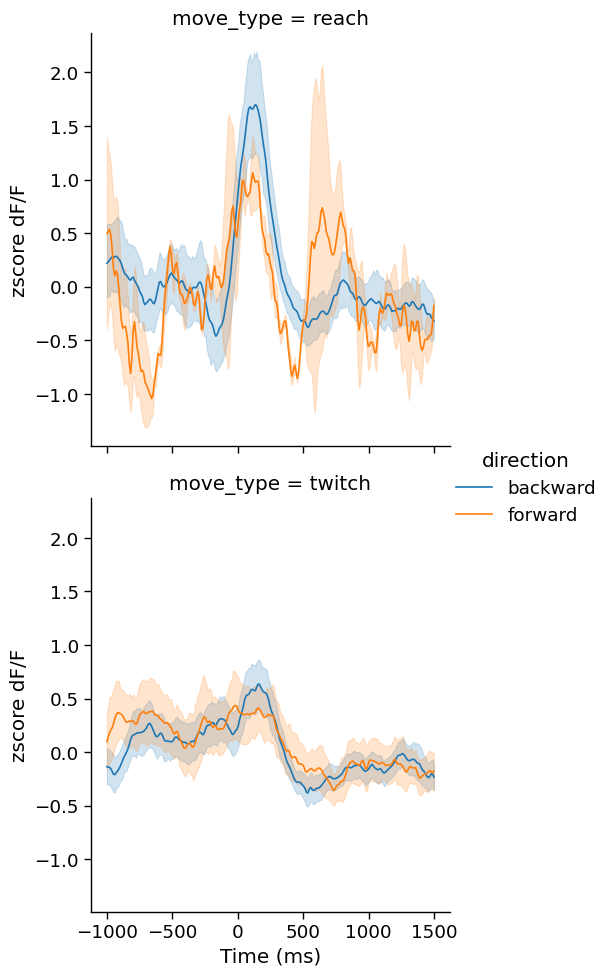

In [102]:
df2plot = df_term2

display(df_term_time.groupby(['move_type','direction']).count())

g = sns.relplot(df2plot, kind='line', x='event_time',
                y='photometry', hue='direction', row='move_type')
g.set_xlabels('Time (ms)')
g.set_ylabels('zscore dF/F')
plt.savefig('photom_movement_type_term.png',dpi=200)

In [104]:
df_speed_class = df_term_time.groupby(['move_type','direction']).first().reset_index()
df_speed_class

for _, row in df_speed_class.iterrows():
    dlc_utils.extract_sample_video_multi(videofile, f'{row.direction}_{row.move_type}_term', 
                                     [row.term_time], video_type='gif', resize_ratio=0.4)

AttributeError: 'DataFrameGroupBy' object has no attribute 'second'

 Things to study
 - Forward aceleration and backward acceleration
 - acceleraton and deceleration

## Speed and photom

<Axes: xlabel='speed', ylabel='df/f'>

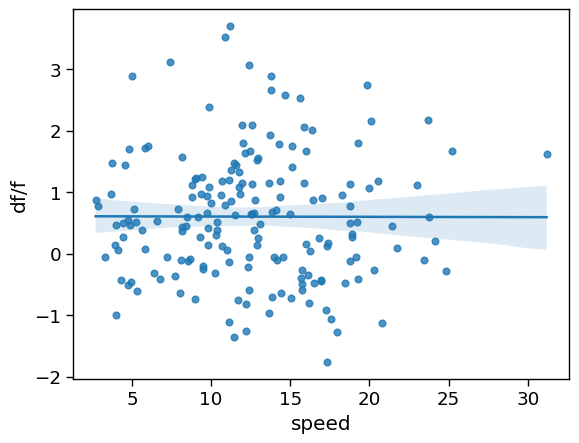

In [318]:
sns.regplot(df_init_time, x='speed', y='df/f')

## TODO
- Segregate based on position

AttributeError: module 'matplotlib.pylab' has no attribute 'adjust_subplots'

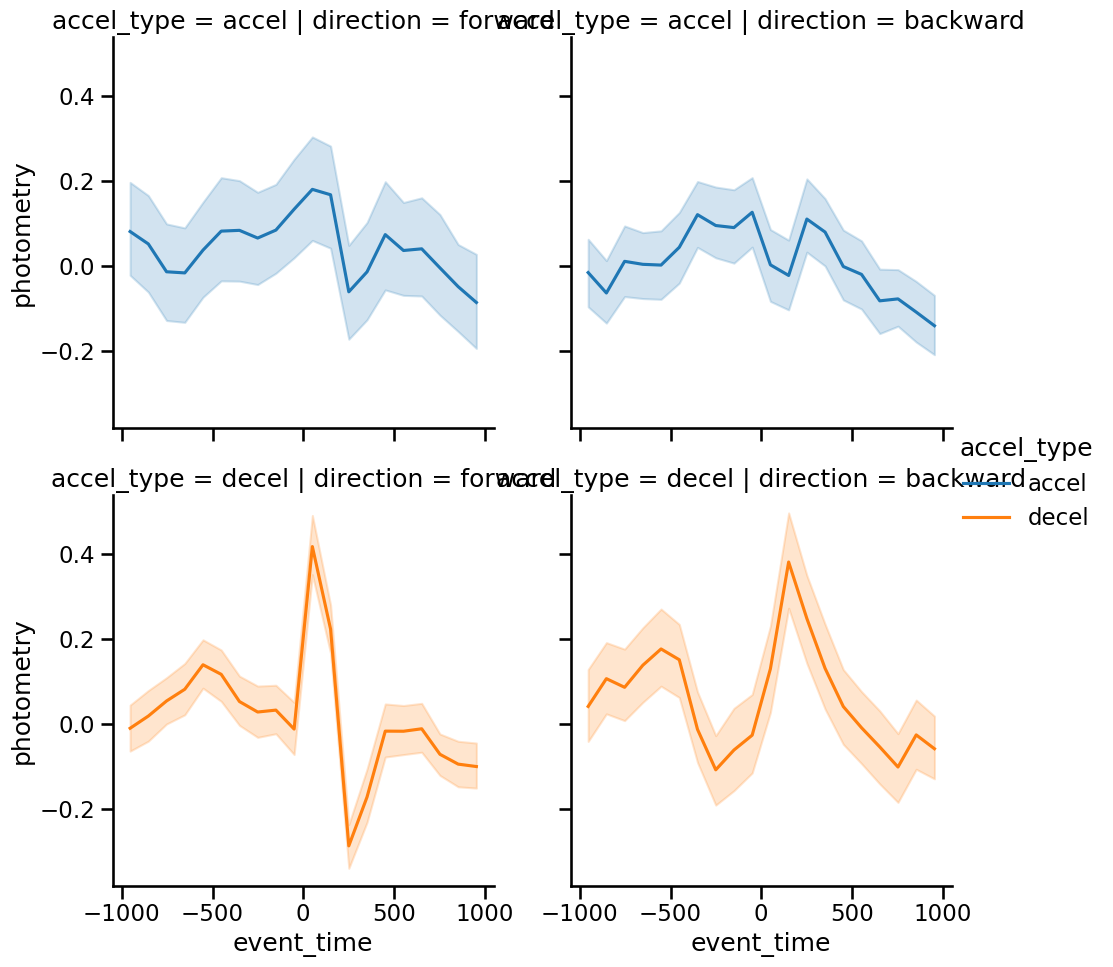

In [ ]:
sns.set_context('talk')
sns.relplot(df2plot, kind='line', x='event_time', y='photometry', hue='accel_type', 
            row='accel_type', col='direction')
plt.adjust_subplots(wspace=0.2)

## Distribution analysis

<Axes: xlabel='accel', ylabel='df/f'>

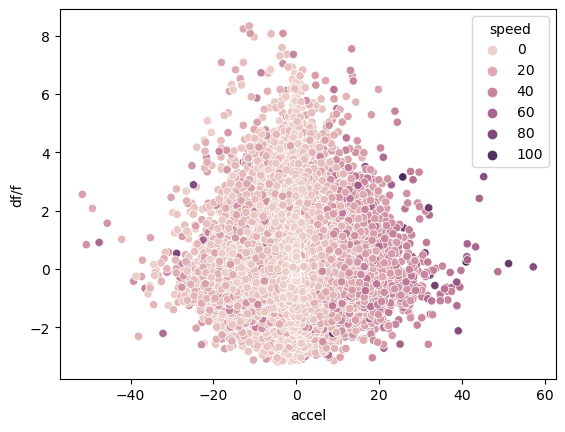

In [12]:
sns.scatterplot(df_vigor, x='accel', y='df/f', hue='speed')

<Axes: xlabel='speed', ylabel='df/f'>

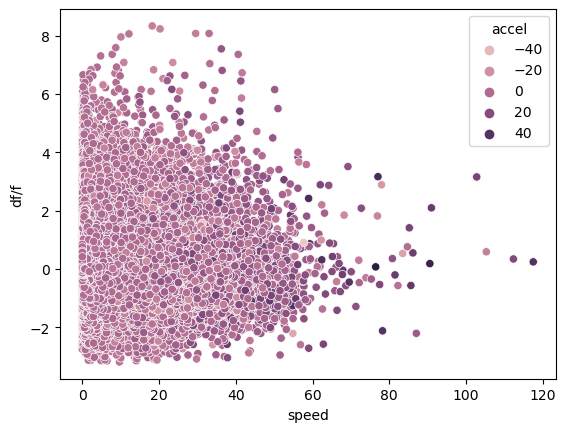

In [13]:
sns.scatterplot(df_vigor, x='speed', y='df/f', hue='accel')